In [1]:
# (Optional, for Colab)
from google.colab import files
_ = files.upload()  # 上傳 hw03-data.npz

Saving hw03-data.npz to hw03-data.npz


Loaded: len(rates)=384, delta_t=0.0078125s, duration=3.000000s
rate(min/mean/max) = 0.000000/9.190571/20.826133 Hz


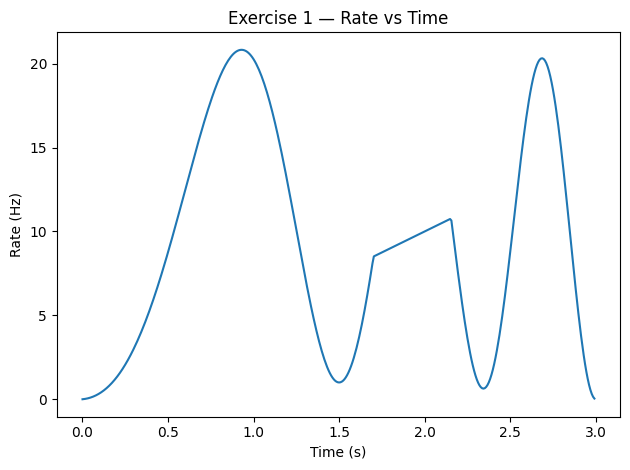

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_rate_data(npz_path):
    """
    Parameters
    ----------
    npz_path : str
        Path to hw03-data.npz
    """
    f = np.load(npz_path)
    rates = f["rates"]
    # delta_t 存成 0-D array；用 .item() 取出純量
    delta_t = f["delta_t"].item() if f["delta_t"].shape == () else float(f["delta_t"])
    t = np.arange(len(rates)) * delta_t
    duration = delta_t * len(rates)
    return rates, delta_t, t, duration

def main():
    # Step 1) 載入資料
    rates, delta_t, t, duration = load_rate_data("hw03-data.npz")
    print(f"Loaded: len(rates)={len(rates)}, delta_t={delta_t:g}s, duration={duration:.6f}s")
    print(f"rate(min/mean/max) = {rates.min():.6f}/{rates.mean():.6f}/{rates.max():.6f} Hz")

    # Step 2) 繪圖
    plt.figure()
    plt.plot(t, rates)
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.title("Exercise 1 — Rate vs Time")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Generated 100 trials. Example lengths (first 5): [25, 26, 23, 24, 28]


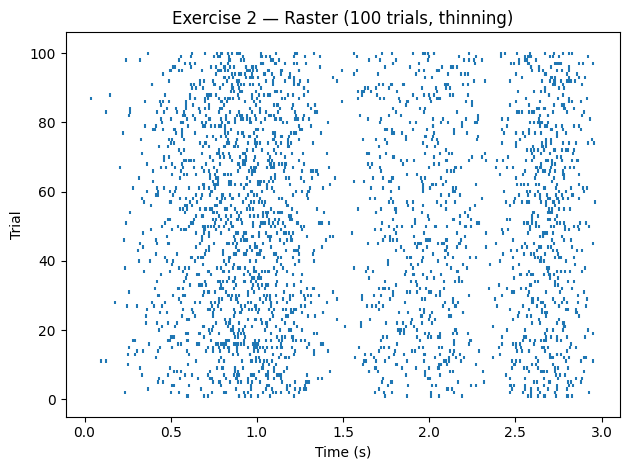

In [3]:
"""
老師說不要使用講義 gen_spikes（那是另一種演算法）後面要教。
"""

import numpy as np
import matplotlib.pyplot as plt

def load_rate_data(npz_path):
    """
    Parameters
    ----------
    npz_path : str
        Path to hw03-data.npz
    """
    f = np.load(npz_path)
    rates = f["rates"]
    delta_t = f["delta_t"].item() if f["delta_t"].shape == () else float(f["delta_t"])
    t = np.arange(len(rates)) * delta_t
    duration = delta_t * len(rates)
    return rates, delta_t, t, duration

def raster_random_points_in_box(rates, delta_t, trials=100, seed=0):
    """
    用上界速率 thinning 產生多條非齊次 Poisson spike trains。
    步驟：
      1) M = max(rates), T = len(rates) * delta_t
      2) N ~ Poisson(M*T)
      3) 候選時間 cand ~ Uniform(0, T)（排序僅為觀察方便）
      4) 以 p = r(cand)/M 的機率接受
    """
    rng = np.random.default_rng(seed)
    T = len(rates) * delta_t
    M = float(np.max(rates))
    spikes_all = []

    for k in range(trials):
        # 候選點數
        N = rng.poisson(M * T)
        if N == 0:
            spikes_all.append(np.array([], dtype=float))
            continue

        # 候選時間
        cand = rng.uniform(0.0, T, size=N)
        cand.sort()

        # 取近鄰索引對映到 rates(t)
        idx = (cand / delta_t).astype(int)
        idx = np.minimum(idx, len(rates) - 1)

        # 接受機率
        p = rates[idx] / M if M > 0 else np.zeros_like(cand)

        # 接受/丟棄
        keep = rng.uniform(0.0, 1.0, size=N) < p
        spikes_all.append(cand[keep])

    return spikes_all

def main():
    rates, delta_t, t, duration = load_rate_data("hw03-data.npz")
    spikes_all = raster_random_points_in_box(rates, delta_t, trials=100, seed=0)
    print(f"Generated {len(spikes_all)} trials. Example lengths (first 5): {[len(s) for s in spikes_all[:5]]}")

    # raster：每列一個 trial
    plt.figure()
    plt.eventplot(spikes_all, lineoffsets=np.arange(1, len(spikes_all) + 1))
    plt.xlabel("Time (s)")
    plt.ylabel("Trial")
    plt.title("Exercise 2 — Raster (100 trials, thinning)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Trial 100 spikes: count=38


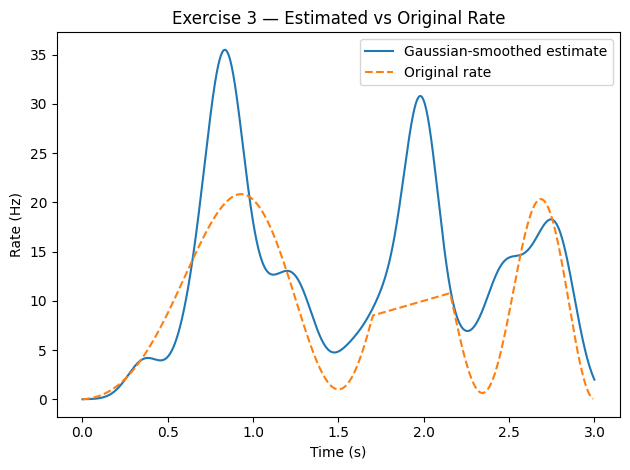

In [4]:
"""
HW03 Ex3 — Frame-based conversion (dt=0.0001s) + Gaussian smoothing (sigma=0.1s)
與原始 rate 疊圖，原始用虛線以對照。
"""

import numpy as np
import matplotlib.pyplot as plt

def load_rate_data(npz_path):
    """
    Parameters
    ----------
    npz_path : str
        Path to hw03-data.npz
    """
    f = np.load(npz_path)
    rates = f["rates"]
    delta_t = f["delta_t"].item() if f["delta_t"].shape == () else float(f["delta_t"])
    t = np.arange(len(rates)) * delta_t
    duration = delta_t * len(rates)
    return rates, delta_t, t, duration

def gaussian_kernel(sigma, frame_dt, width_sigma=5.0):
    """
    建立離散 Gaussian 核；截斷於 ±(width_sigma * sigma)
    並以 kernel.sum() * frame_dt = 1 做正規化（離散近似連續積分=1）。
    """
    half = int(np.ceil(width_sigma * sigma / frame_dt))
    x = np.arange(-half, half + 1) * frame_dt
    g = np.exp(-0.5 * (x / sigma) ** 2)
    g /= g.sum() * frame_dt
    return x, g

def raster_random_points_in_box(rates, delta_t, trials=100, seed=0):
    """
    與 Ex2 相同的 thinning 產生多條 spikes（為了自洽，這裡再放一次）。
    """
    rng = np.random.default_rng(seed)
    T = len(rates) * delta_t
    M = float(np.max(rates))
    spikes_all = []
    for k in range(trials):
        N = rng.poisson(M * T)
        if N == 0:
            spikes_all.append(np.array([], dtype=float))
            continue
        cand = rng.uniform(0.0, T, size=N)
        cand.sort()
        idx = (cand / delta_t).astype(int)
        idx = np.minimum(idx, len(rates) - 1)
        p = rates[idx] / M if M > 0 else np.zeros_like(cand)
        keep = rng.uniform(0.0, 1.0, size=N) < p
        spikes_all.append(cand[keep])
    return spikes_all

def main():
    rates, delta_t, t, duration = load_rate_data("hw03-data.npz")
    spikes_all = raster_random_points_in_box(rates, delta_t, trials=100, seed=0)

    # 取第 100 條（0-based index 99）
    spikes = spikes_all[99]
    print(f"Trial 100 spikes: count={spikes.size}")

    # frame-based（固定更細的取樣）：注意與原始 delta_t 不同
    frame_dt = 1e-4   # 0.0001 s
    frame_times = np.arange(0.0, duration, frame_dt)
    frames = np.zeros_like(frame_times)
    if spikes.size > 0:
        idx = (spikes / frame_dt).astype(int)
        idx = idx[idx < len(frames)]  # 邊界保護
        frames[idx] = 1

    # Gaussian 平滑
    sigma = 0.1  # s
    _, g = gaussian_kernel(sigma, frame_dt)
    rate_est = np.convolve(frames, g, mode="same")

    # 疊圖比較（原始率虛線）
    plt.figure()
    plt.plot(frame_times, rate_est, label="Gaussian-smoothed estimate")
    plt.plot(t, rates, "--", label="Original rate")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.title("Exercise 3 — Estimated vs Original Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()